In [1]:
# Import necessery libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset ,Subset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split


In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [5]:
# get filker data from kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k
! unzip /content/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [6]:
# locate dataset contents
image_data_location = "/content/Images"
caption_data_location = "/content/captions.txt"

df = pd.read_csv(caption_data_location)

In [7]:
spacy_eng = spacy.load('en_core_web_sm')

In [8]:
# Load the English tokenizer from Spacy
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        # Add special tokens
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        # Frequency threshold for including words in the vocabulary
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        # Tokenize text using Spacy and convert to lowercase
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        # Counter to keep track of word frequencies
        frequencies = Counter()
        # Start index for new words in the vocabulary
        idx = 4
        # Iterate over each sentence
        for sentence in sentence_list:
            # Tokenize the sentence
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                # If word frequency reaches the threshold, add it to vocabulary
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # Tokenize the text
        tokenized_text = self.tokenize(text)
        # Convert tokens to their corresponding indices in the vocabulary
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]


In [10]:
# Create a costum dataset to read image names from caption.txt and give the
# corresponing caption as output. the caption would be numericalize and images
# would be transformed to the desiered shape
class CustomDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)

        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        # all sentences start with <SOS>
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        # all sentences end with <EOS>
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [11]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [12]:
# create a function to show the image from tensor
def show_image(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [13]:
# create the dataset
dataset = CustomDataset(
        root_dir = image_data_location,
        captions_file = caption_data_location,
        transform = transforms
)


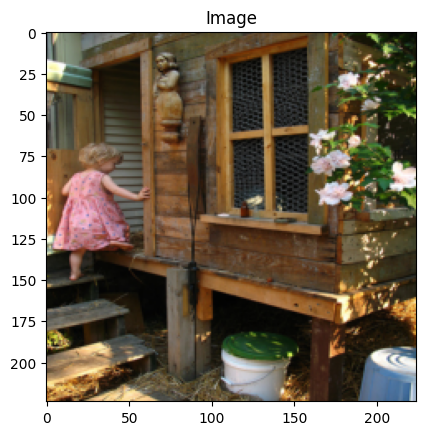

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [14]:
# this is an example of an image with it's corresponing caption and it's tokens
img, caps = dataset[0]
# print(caps)
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [15]:
# this class pads the targets to make them equal in length within a batch
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        # get images and concat them into one tensor
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        # get captions and make them equal size
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets


In [16]:
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

# split the original dataset to training and testing datasets
dataset_size = len(dataset)
train_indices, test_indices = train_test_split(list(range(dataset_size)), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

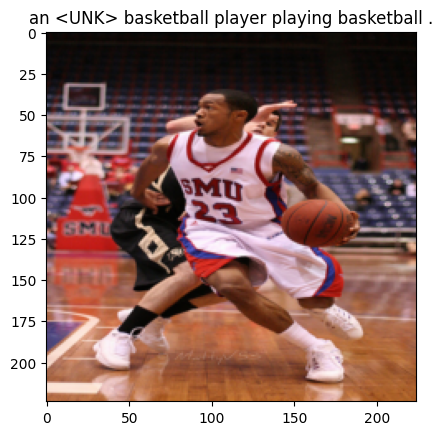

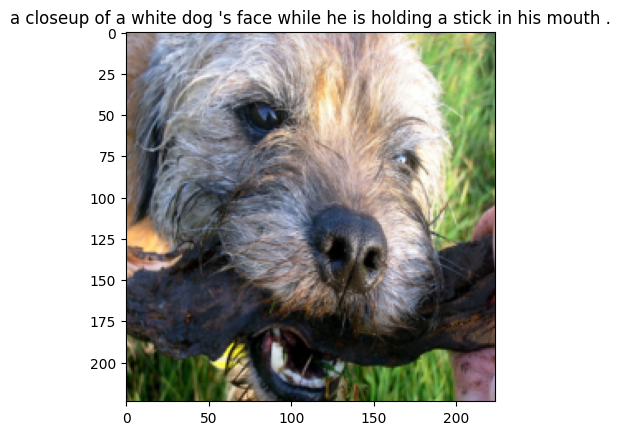

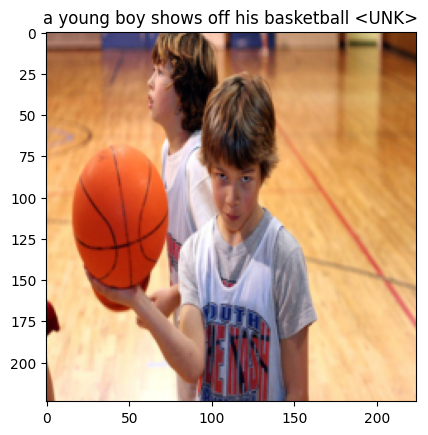

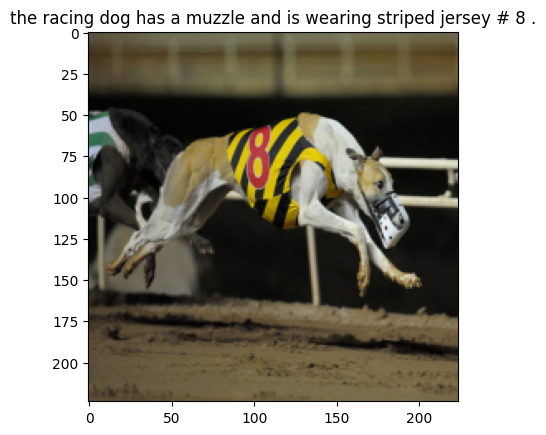

In [17]:
#generating the iterator from the dataloader
dataiter = iter(train_dataloader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [20]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(True)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

    def forward(self,images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self,features, captions):
        # vectorize the caption
        embeds = self.embedding(captions[:,:-1])
        # concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):

        # Inference part , Given the image features generate the captions
        batch_size = inputs.size(0)
        captions = []

        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)

            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]


class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [22]:
# Hyperparameters
embed_size = 300
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001

In [21]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.4MB/s]


1
Epoch: 1 loss: 3.51879
features shape - torch.Size([1, 300])
<SOS> a man in a red shirt is running on a field . <EOS>


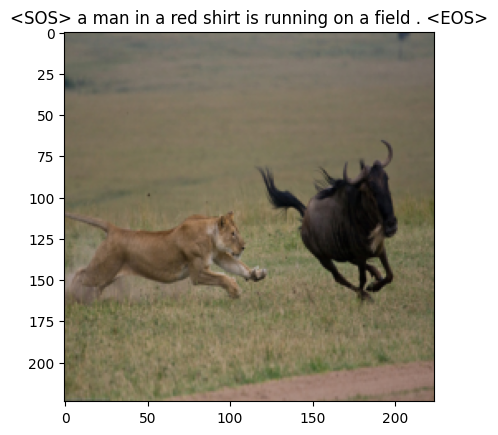

2
Epoch: 2 loss: 3.52350
features shape - torch.Size([1, 300])
<SOS> a dog is running through the grass . <EOS>


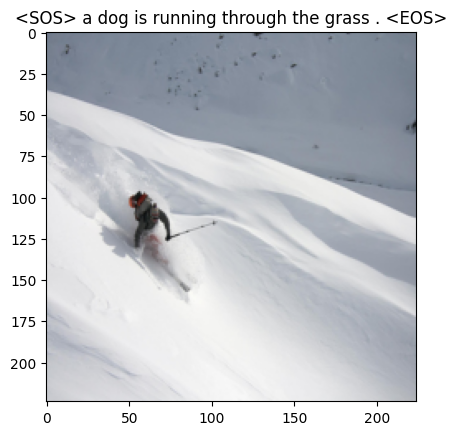

3
Epoch: 3 loss: 2.38182
features shape - torch.Size([1, 300])
<SOS> a man in a blue shirt is standing on a bench . <EOS>


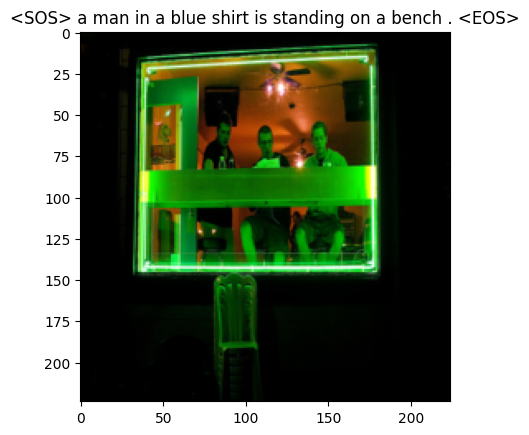

4
Epoch: 4 loss: 2.83669
features shape - torch.Size([1, 300])
<SOS> a dog is running through the snow . <EOS>


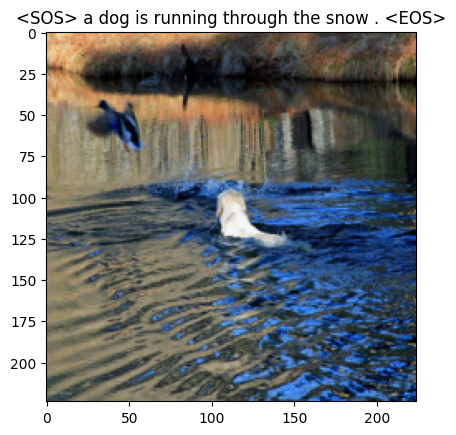

5
Epoch: 5 loss: 2.29555
features shape - torch.Size([1, 300])
<SOS> a man in a red shirt is standing in front of a building . <EOS>


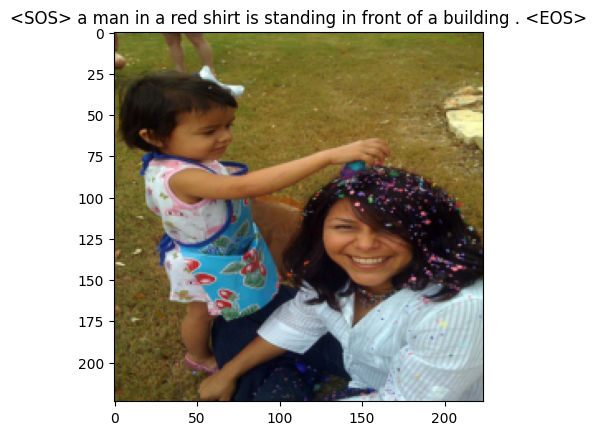

6
Epoch: 6 loss: 2.04008
features shape - torch.Size([1, 300])
<SOS> a man in a black jacket is standing on a rock . <EOS>


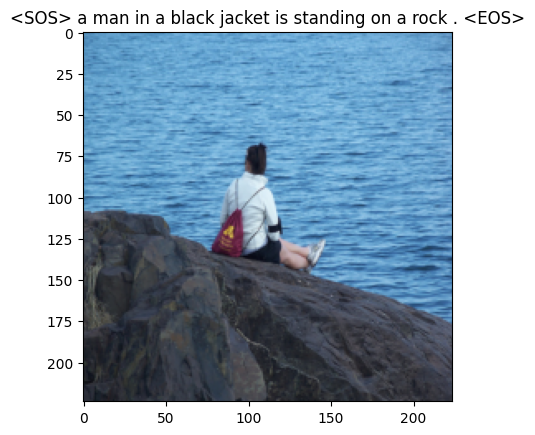

7
Epoch: 7 loss: 2.22395
features shape - torch.Size([1, 300])
<SOS> a dog is running through the grass . <EOS>


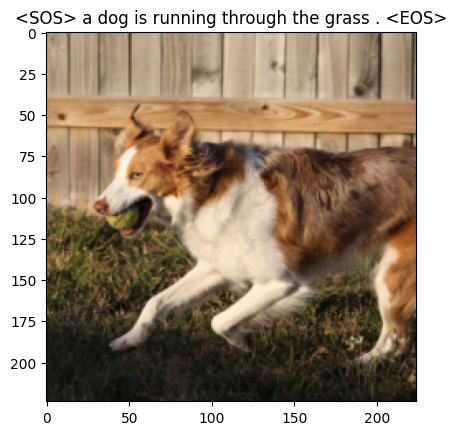

8
Epoch: 8 loss: 2.62411
features shape - torch.Size([1, 300])
<SOS> a man in a wetsuit is surfing . <EOS>


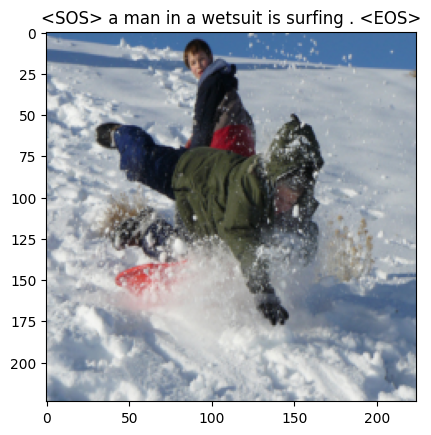

9
Epoch: 9 loss: 3.02414
features shape - torch.Size([1, 300])
<SOS> a man in a black shirt and a woman in a black shirt and a white dog are standing


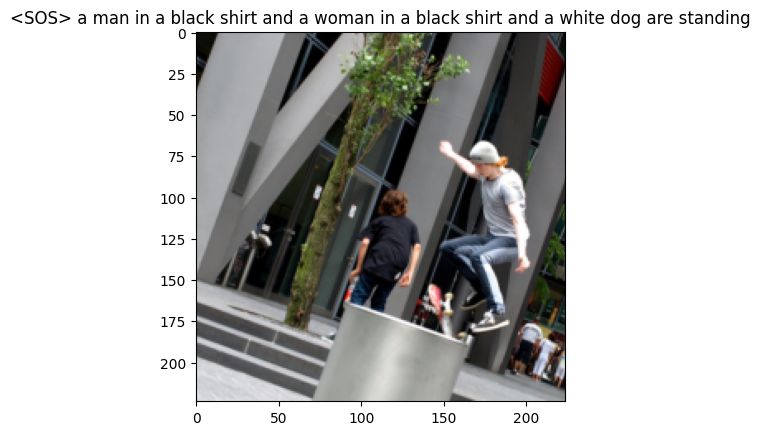

10
Epoch: 10 loss: 2.10269
features shape - torch.Size([1, 300])
<SOS> a man in a blue shirt is standing on a bench in front of a building . <EOS>


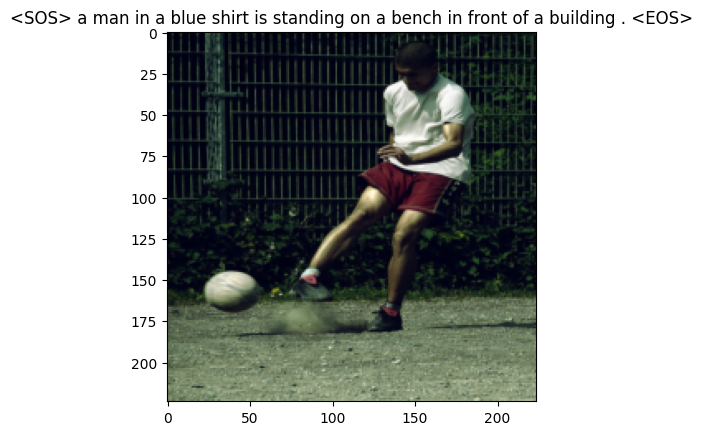

In [23]:
num_epochs = 10
print_every = 5000

my_loss_train= []
my_loss_test= []

dataiter_test = iter(test_dataloader)

for epoch in range(1,num_epochs+1):
    print(epoch)
    for idx, (image, captions) in enumerate(iter(train_dataloader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))


        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        my_loss_train.append(loss.item())

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                img,_ = next(dataiter_test)
                features = model.encoder(img[0:1].to(device))
                print(f"features shape - {features.shape}")
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title=caption)

            model.train()

In [27]:
# save model
torch.save(model , '/content/drive/MyDrive/mymodel')

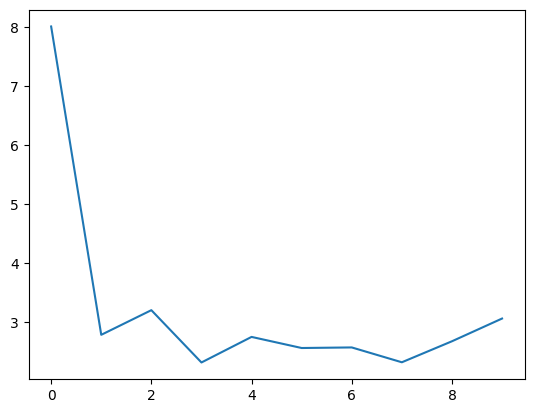

In [29]:
# plot training loss
plt.plot(my_loss_train[::8091])

In [30]:
#generate the caption
dataiter = iter(test_dataloader)
model.eval()

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

features shape - torch.Size([1, 300])
<SOS> a dog is running through the snow . <EOS>


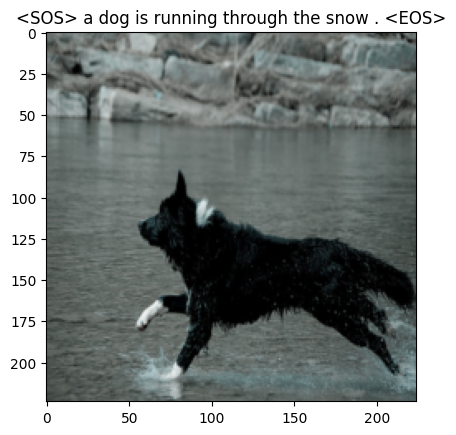

In [54]:
# get inferances from trained network
with torch.no_grad():
  img,_ = next(dataiter)
  features = model.encoder(img[0:1].to(device))
  print(f"features shape - {features.shape}")
  caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
  caption = ' '.join(caps)
  print(caption)
  show_image(img[0],title=caption)